In [2]:
import numpy as np
from astropy.io import fits
import datetime 
import matplotlib.pyplot as plt
import sys
sys.path.append('../radiospectra2')
from radiospectra.sources import CallistoSpectrogram
import cv2
from Orfees_read import *

/home/delberin/eCallistoValidation/validation/Orfees/../radiospectra2/radiospectra/version.py:12: UserWarning: could not determine radiospectra package version; this indicates a broken installation
  warnings.warn(


the Orfees methods are imported....


In [3]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/BIR_20151104_120000_03.fit.gz')
min_freq = spec.freq_axis.min()
max_freq = spec.freq_axis.max()

print(min_freq, "  ", max_freq)
mask = (orfees.freq_axis > min_freq) & (orfees.freq_axis < max_freq)
range_freq = orfees.freq_axis[mask]

print(range_freq.min(), "  ", range_freq.max())
range_pixels = orfees.data[mask, :]

200.0    403.625
200.38    403.0


In [4]:
def range_pix(orfees, spce):

    min_freq = spce.freq_axis.min()
    max_freq = spce.freq_axis.max()
    mask = (orfees.freq_axis > min_freq) & (orfees.freq_axis < max_freq)
    range_freq = orfees.freq_axis[mask]
    range_pixels = orfees.data[mask, :]
    
    return range_pixels, min_freq, max_freq, range_freq

/tmp/ipykernel_2212/2107689197.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")


Text(0, 0.5, 'Frequency [MHz]')

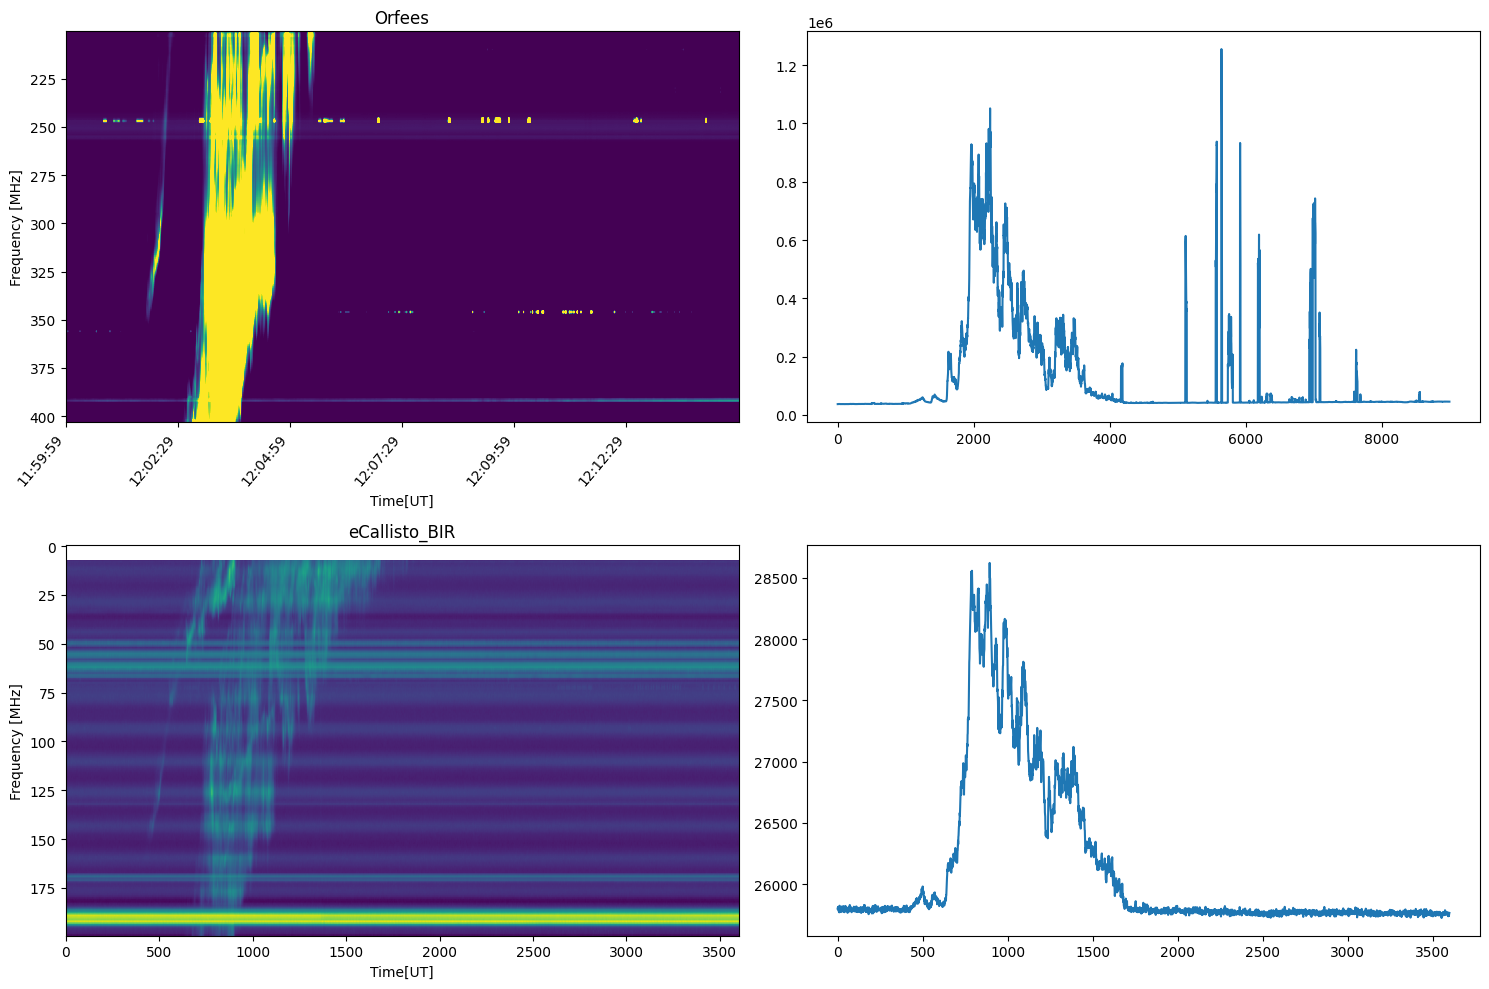

In [5]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
spec =CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/BIR_20151104_120000_03.fit.gz')


dates = orfees.convert_ms_to_date()

_data, min_freq, max_freq, range = range_pix(orfees, spec)
orfees_min = min(range)
orfees_max = max(range)
# print(_data)
plt.rcParams["figure.autolayout"] = True

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].xaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
axs[0, 0].set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")
axs[0, 0].imshow(_data,vmin=100, vmax=1000, aspect="auto")

axs[0, 0].set_title("Orfees")
axs[0, 0].set_ylim(orfees_max, orfees_min)
axs[0, 0].set_xlabel('Time[UT]')
axs[0, 0].set_ylabel('Frequency [MHz]')

axs[1, 0].imshow(spec.data[::-1], aspect="auto")
# axs[1, 0].set_ylim(max_freq, min_freq)
axs[1, 0].set_title("eCallisto_BIR")
axs[0, 1].plot(_data.sum(axis=0))
# axs[0, 1].set_yscale('log') 
axs[1, 1].plot(spec.data.sum(axis=0))

axs[1, 0].set_xlabel('Time[UT]')
axs[1, 0].set_ylabel('Frequency [MHz]')

/tmp/ipykernel_2212/1688649823.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")
/tmp/ipykernel_2212/1688649823.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")
/tmp/ipykernel_2212/1688649823.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_yticklabels(np.arange(min_freq, max_freq, 25))


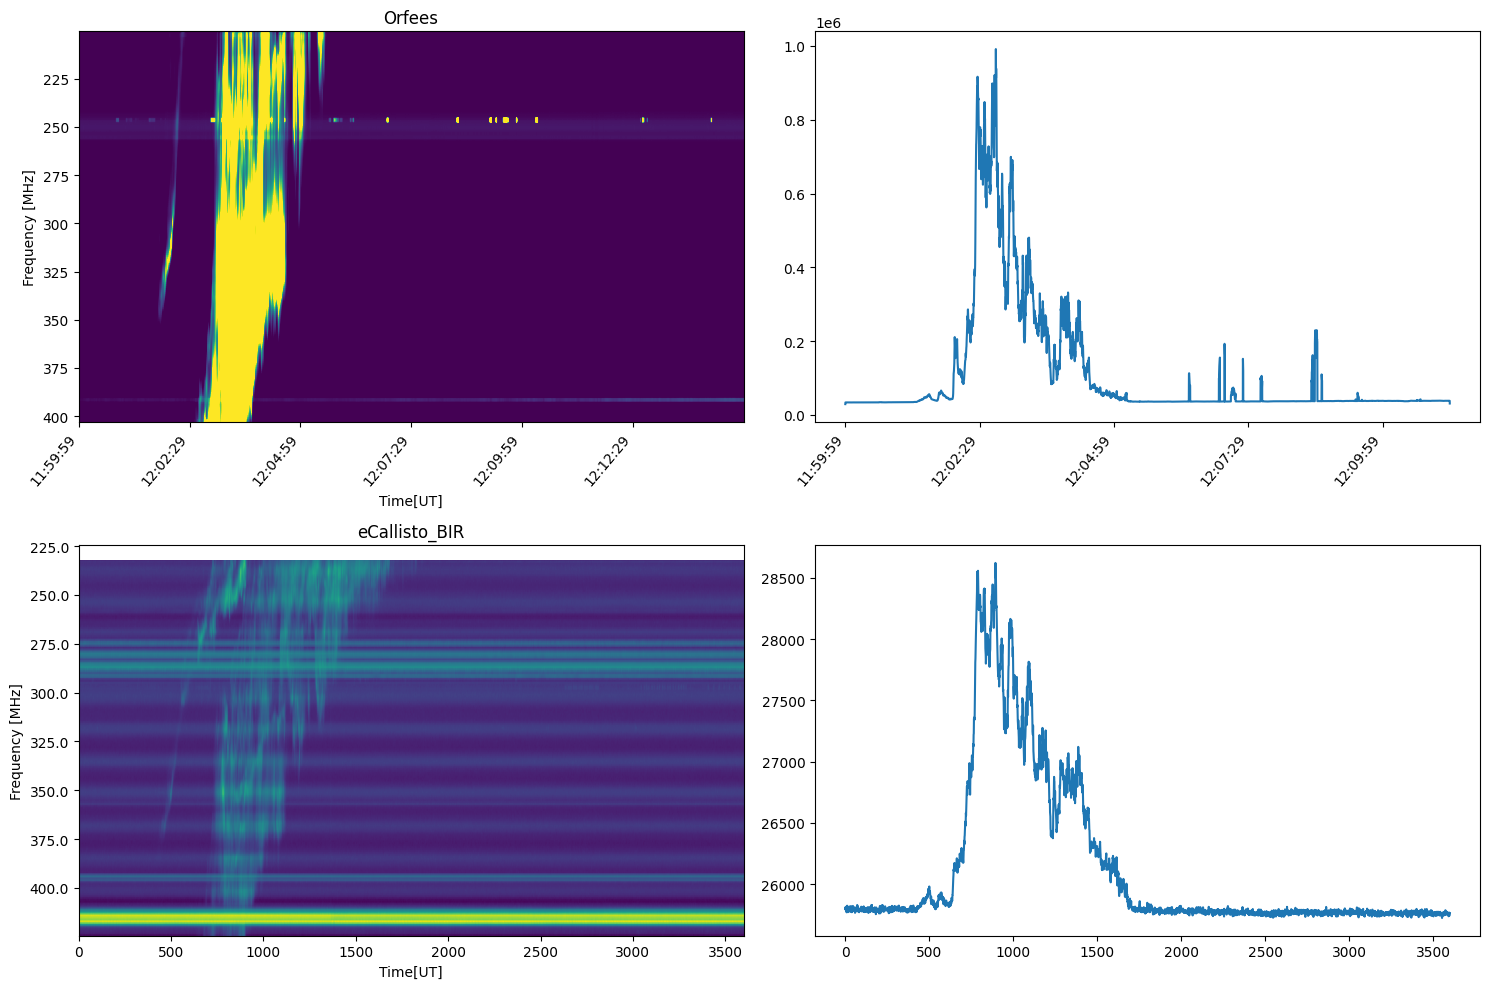

In [14]:
from scipy import signal
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/BIR_20151104_120000_03.fit.gz')
dates = orfees.convert_ms_to_date()

_data, min_freq, max_freq, range = range_pix(orfees, spec)
filtered_data = signal.medfilt2d(_data, 3)

orfees_min = min(range)
orfees_max = max(range)

plt.rcParams["figure.autolayout"] = True

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Set the same major locator and tick labels for both time axes
axs[0, 0].xaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
axs[0, 0].set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")

axs[0, 1].xaxis.set_major_locator(MaxNLocator(prune='both', nbins=6))
axs[0, 1].set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")

# orfees
axs[0, 0].imshow(filtered_data, vmin=100, vmax=1000, aspect="auto")
axs[0, 0].set_title("Orfees")
axs[0, 0].set_ylim(orfees_max, orfees_min)
axs[0, 0].set_xlabel('Time[UT]')
axs[0, 0].set_ylabel('Frequency [MHz]')

# ecallisto
axs[1, 0].imshow(spec.data[::-1], aspect="auto")

axs[1, 0].set_title("eCallisto_BIR")
axs[1, 0].set_yticklabels(np.arange(min_freq, max_freq, 25))
# axs[1, 0].set_ylim(max_freq, min_freq)
# axs[1, 0].set_yticks(np.arange(min_freq, max_freq, 25))
axs[1, 0].set_xlabel('Time[UT]')
axs[1, 0].set_ylabel('Frequency [MHz]')

axs[0, 1].plot(filtered_data.sum(axis=0))
axs[1, 1].plot(spec.data.sum(axis=0))

plt.show()

/home/delberin/eCallistoValidation/validation/Orfees/Orfees_read.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")
/home/delberin/eCallistoValidation/validation/Orfees/Orfees_read.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(dates[::int(len(dates)//30)], rotation=50, horizontalalignment="right")


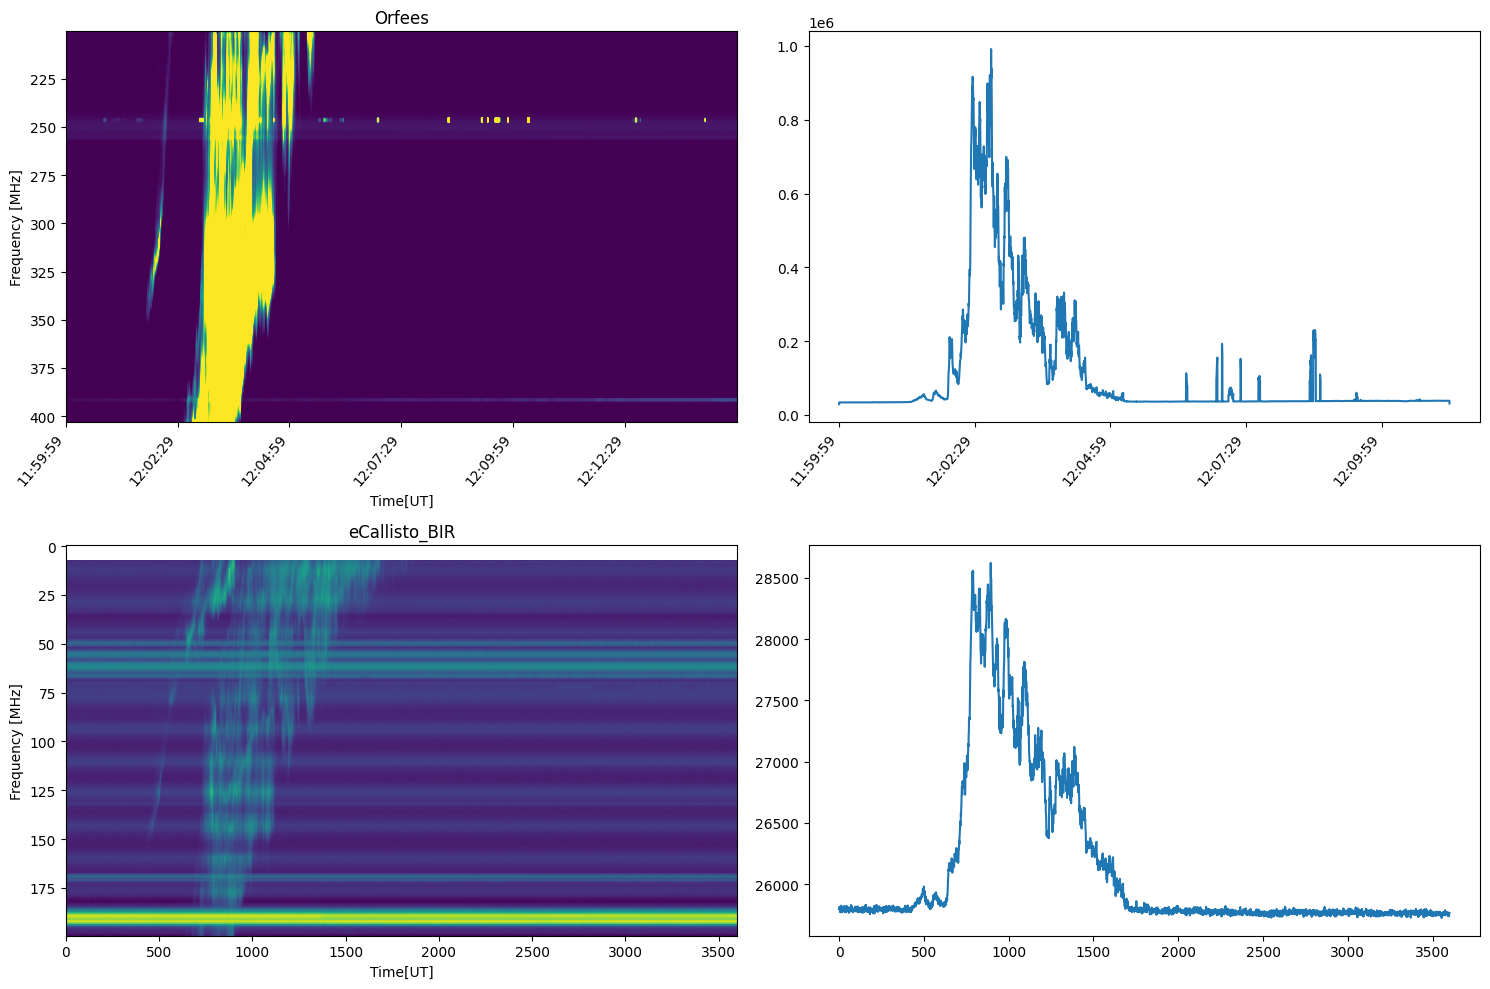

In [11]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
spec = CallistoSpectrogram.from_url('http://soleil.i4ds.ch/solarradio/data/2002-20yy_Callisto/2015/11/04/BIR_20151104_120000_03.fit.gz')
dates = orfees.convert_ms_to_date()
fig, axs = orfees.plot_subplots(spec, dates)
plt.show()